# ACS PUMS Weighted Analysis

This notebook uses **proper survey weights** for population-representative estimates.

- `PWGTP` = Person weight (for person-level estimates)
- `WGTP` = Household weight (for household-level estimates)

**Important**: Unweighted counts show sample sizes. Weighted estimates represent the actual US population.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))
from analysis.code_mappings import (
    STATE_CODES, EDUCATION_CODES, SEX_CODES, RACE_CODES,
    EMPLOYMENT_STATUS_CODES, CLASS_OF_WORKER_CODES, TENURE_CODES,
    BUILDING_TYPE_CODES, HOUSEHOLD_TYPE_CODES,
    get_education_category, estimate_education_years
)

# Weighted statistics functions
def weighted_median(values, weights):
    """Calculate weighted median."""
    df = pd.DataFrame({'value': values, 'weight': weights}).dropna()
    df = df.sort_values('value')
    cumsum = df['weight'].cumsum()
    cutoff = df['weight'].sum() / 2
    return df[cumsum >= cutoff]['value'].iloc[0]

def weighted_mean(values, weights):
    """Calculate weighted mean."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    return np.average(values[mask], weights=weights[mask])

def weighted_percentile(values, weights, percentile):
    """Calculate weighted percentile."""
    df = pd.DataFrame({'value': values, 'weight': weights}).dropna()
    df = df.sort_values('value')
    cumsum = df['weight'].cumsum()
    cutoff = df['weight'].sum() * percentile / 100
    return df[cumsum >= cutoff]['value'].iloc[0]

plt.style.use('seaborn-v0_8-whitegrid')
print("Imports loaded successfully!")

Imports loaded successfully!


In [8]:
DATA_DIR = Path('../data')

df_hh = pd.read_csv(DATA_DIR / 'pums_household_2023.csv', low_memory=False)
df_hh_sample = df_hh.sample(frac=0.99, random_state=42)
print(f"Household: {len(df_hh):,} records, using {len(df_hh_sample):,} sample (20%)")
print(f"  Weighted total: {df_hh_sample['wgtp'].sum() * 5:,.0f} households")

df_person = pd.read_csv(DATA_DIR / 'pums_person_2023.csv', low_memory=False)
df_person_sample = df_person.sample(frac=0.99, random_state=42)
print(f"Person: {len(df_person):,} records, using {len(df_person_sample):,} sample (20%)")
print(f"  Weighted total: {df_person_sample['pwgtp'].sum() * 5:,.0f} persons")

Household: 1,620,290 records, using 1,604,087 sample (20%)
  Weighted total: 719,409,170 households
Person: 3,405,809 records, using 3,371,751 sample (20%)
  Weighted total: 1,657,908,300 persons


In [9]:
# Add descriptive labels
df_hh_sample['state_name'] = df_hh_sample['st'].map(STATE_CODES)
df_hh_sample['tenure_desc'] = df_hh_sample['ten'].map(TENURE_CODES)
df_hh_sample['building_type'] = df_hh_sample['bld'].map(BUILDING_TYPE_CODES)
df_hh_sample['household_type'] = df_hh_sample['hht'].map(HOUSEHOLD_TYPE_CODES)

df_person_sample['state_name'] = df_person_sample['st'].map(STATE_CODES)
df_person_sample['sex_desc'] = df_person_sample['sex'].map(SEX_CODES)
df_person_sample['race_desc'] = df_person_sample['rac1p'].map(RACE_CODES)
df_person_sample['education_category'] = df_person_sample['schl'].apply(get_education_category)
df_person_sample['employment_status'] = df_person_sample['esr'].map(EMPLOYMENT_STATUS_CODES)
df_person_sample['class_of_worker'] = df_person_sample['cow'].map(CLASS_OF_WORKER_CODES)
df_person_sample['education_years'] = df_person_sample['schl'].apply(estimate_education_years)
df_person_sample['experience'] = (df_person_sample['agep'] - df_person_sample['education_years'] - 6).clip(lower=0)
print("Labels added!")

Labels added!


## Weighted Population by State

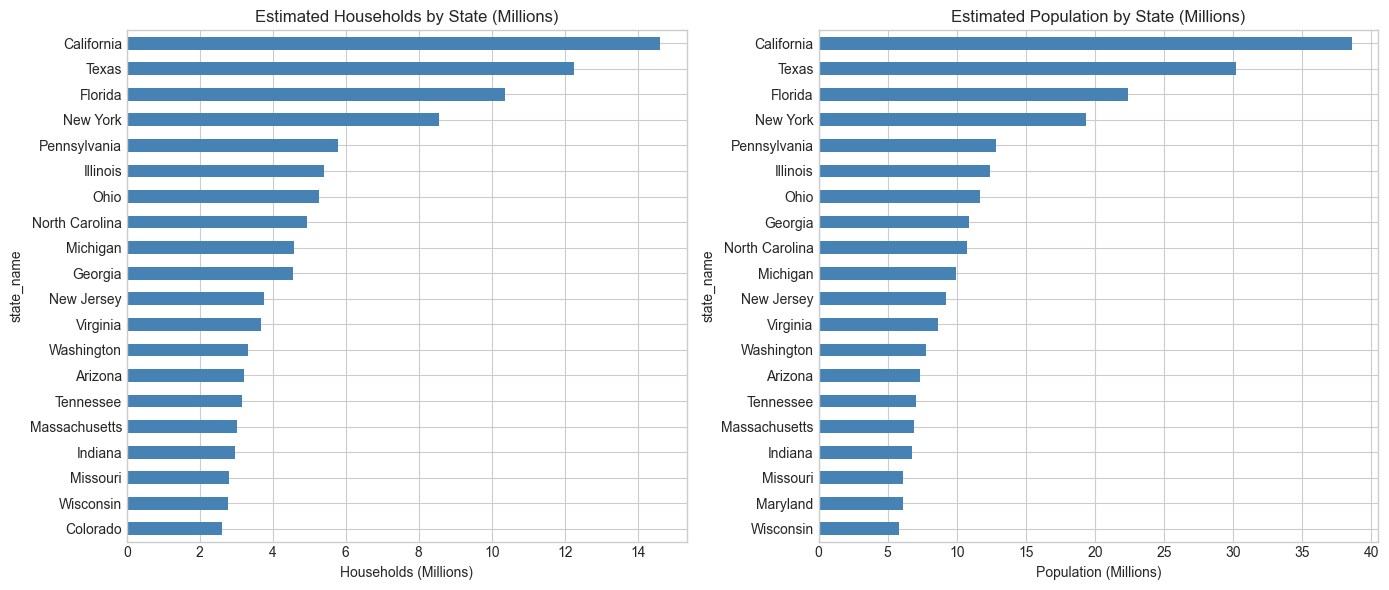


Total weighted households: 143,881,834
Total weighted population: 331,581,660


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Weighted household count by state
ax = axes[0]
state_hh = df_hh_sample.groupby('state_name')['wgtp'].sum().sort_values(ascending=True).tail(20) / 1e6
state_hh.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Estimated Households by State (Millions)', fontsize=12)
ax.set_xlabel('Households (Millions)')

# Weighted person count by state
ax = axes[1]
state_pop = df_person_sample.groupby('state_name')['pwgtp'].sum().sort_values(ascending=True).tail(20) / 1e6
state_pop.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Estimated Population by State (Millions)', fontsize=12)
ax.set_xlabel('Population (Millions)')

plt.tight_layout()
plt.show()

print(f"\nTotal weighted households: {df_hh_sample['wgtp'].sum():,.0f}")
print(f"Total weighted population: {df_person_sample['pwgtp'].sum():,.0f}")

## Weighted Income Statistics

In [11]:
# Filter to positive income households
hh_income = df_hh_sample[df_hh_sample['hincp'] > 0].copy()

# Weighted statistics
w_median = weighted_median(hh_income['hincp'], hh_income['wgtp'])
w_mean = weighted_mean(hh_income['hincp'], hh_income['wgtp'])
w_p25 = weighted_percentile(hh_income['hincp'], hh_income['wgtp'], 25)
w_p75 = weighted_percentile(hh_income['hincp'], hh_income['wgtp'], 75)
w_p90 = weighted_percentile(hh_income['hincp'], hh_income['wgtp'], 90)

# Unweighted for comparison
uw_median = hh_income['hincp'].median()
uw_mean = hh_income['hincp'].mean()

print("Household Income Statistics")
print("="*50)
print(f"{'Statistic':<20} {'Weighted':>15} {'Unweighted':>15}")
print("-"*50)
print(f"{'Median':<20} ${w_median:>14,.0f} ${uw_median:>14,.0f}")
print(f"{'Mean':<20} ${w_mean:>14,.0f} ${uw_mean:>14,.0f}")
print(f"{'25th Percentile':<20} ${w_p25:>14,.0f}")
print(f"{'75th Percentile':<20} ${w_p75:>14,.0f}")
print(f"{'90th Percentile':<20} ${w_p90:>14,.0f}")

Household Income Statistics
Statistic                   Weighted      Unweighted
--------------------------------------------------
Median               $        78,000 $        80,000
Mean                 $       108,685 $       112,019
25th Percentile      $        40,000
75th Percentile      $       135,820
90th Percentile      $       220,000


## Weighted Income by State

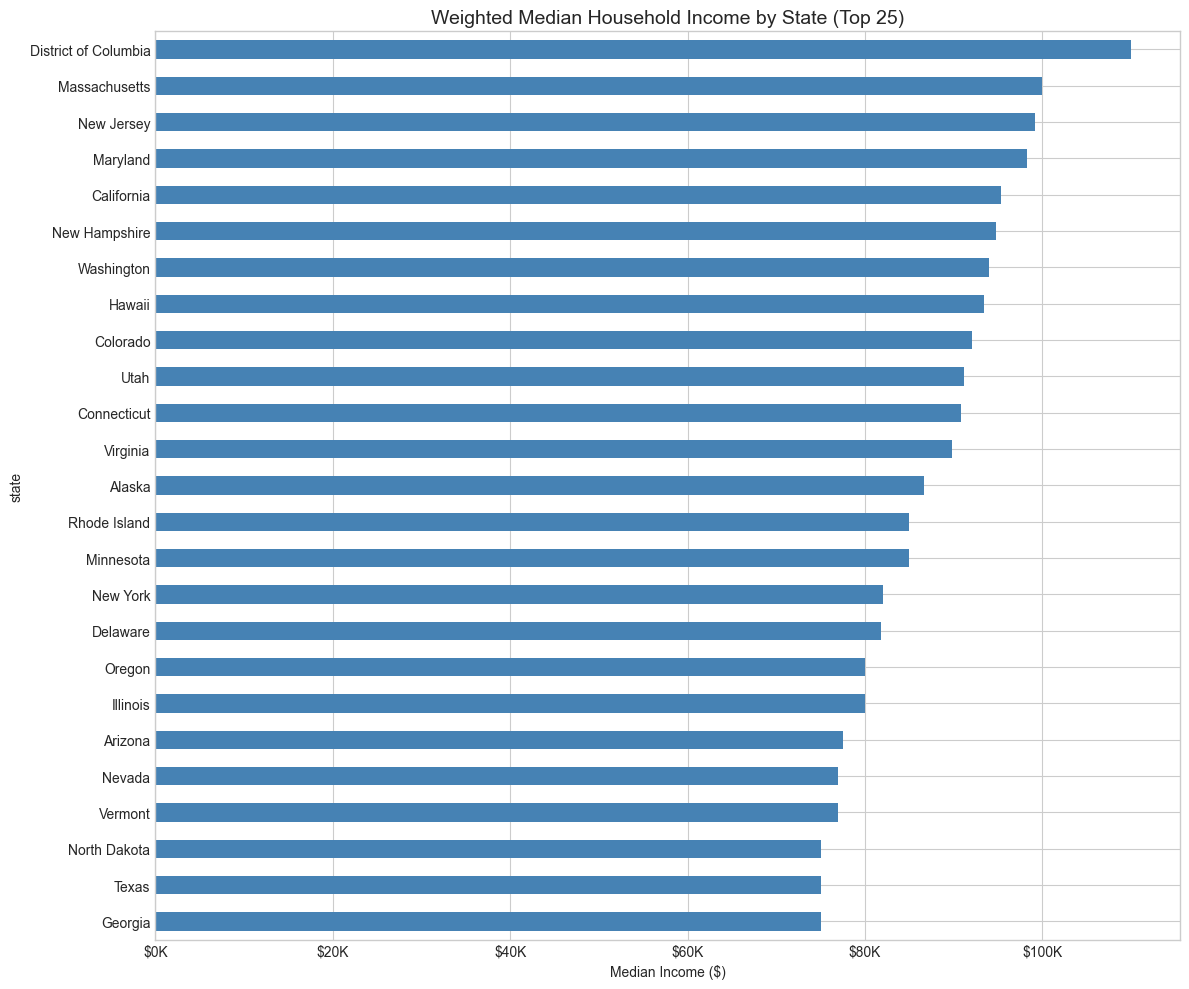

In [12]:
# Calculate weighted median income by state
state_income = []
for state in hh_income['state_name'].dropna().unique():
    state_data = hh_income[hh_income['state_name'] == state]
    w_med = weighted_median(state_data['hincp'], state_data['wgtp'])
    state_income.append({'state': state, 'weighted_median': w_med})

state_income_df = pd.DataFrame(state_income).set_index('state').sort_values('weighted_median', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
state_income_df.tail(25)['weighted_median'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Weighted Median Household Income by State (Top 25)', fontsize=14)
ax.set_xlabel('Median Income ($)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

## Weighted Tenure Distribution

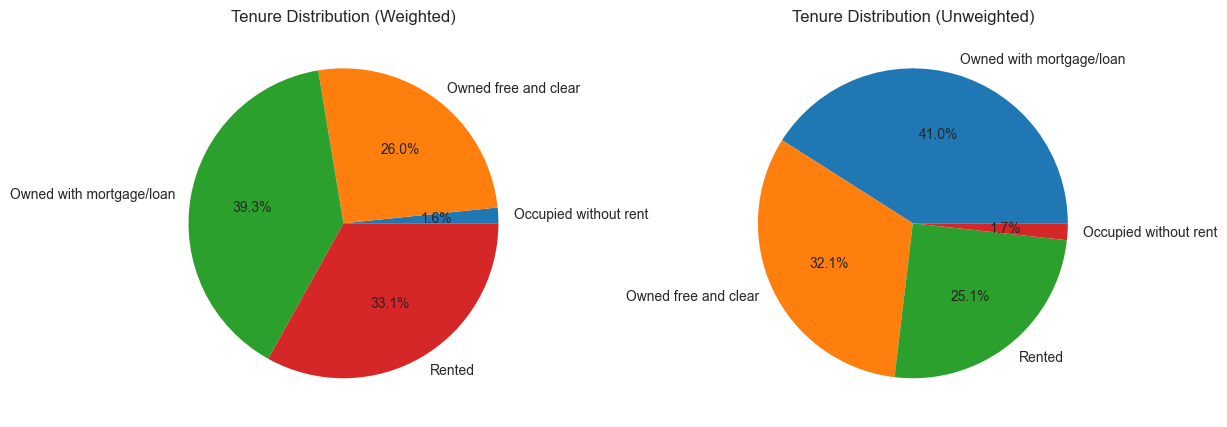

In [13]:
# Weighted tenure distribution
tenure_weighted = df_hh_sample.groupby('tenure_desc')['wgtp'].sum()
tenure_pct = tenure_weighted / tenure_weighted.sum() * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Weighted
ax = axes[0]
tenure_pct.plot(kind='pie', ax=ax, autopct='%1.1f%%')
ax.set_title('Tenure Distribution (Weighted)', fontsize=12)
ax.set_ylabel('')

# Unweighted for comparison
ax = axes[1]
tenure_unweighted = df_hh_sample['tenure_desc'].value_counts(normalize=True) * 100
tenure_unweighted.plot(kind='pie', ax=ax, autopct='%1.1f%%')
ax.set_title('Tenure Distribution (Unweighted)', fontsize=12)
ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Weighted Wages by Education

In [14]:
# Filter to workers with positive wages
workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
print(f"Analyzing {len(workers):,} workers (weighted: {workers['pwgtp'].sum():,.0f})")

edu_order = ['Less than HS', 'High School', 'Some College', "Associate's", 
             "Bachelor's", "Master's", 'Professional', 'Doctorate']

# Calculate weighted median wages by education
edu_wages = []
for edu in edu_order:
    edu_data = workers[workers['education_category'] == edu]
    if len(edu_data) > 0:
        w_med = weighted_median(edu_data['wagp'], edu_data['pwgtp'])
        uw_med = edu_data['wagp'].median()
        count = edu_data['pwgtp'].sum()
        edu_wages.append({'education': edu, 'weighted_median': w_med, 
                         'unweighted_median': uw_med, 'weighted_count': count})

edu_wages_df = pd.DataFrame(edu_wages).set_index('education')

print("\nMedian Wages by Education Level")
print("="*60)
print(f"{'Education':<20} {'Weighted':>15} {'Unweighted':>15}")
print("-"*60)
for edu in edu_order:
    if edu in edu_wages_df.index:
        row = edu_wages_df.loc[edu]
        print(f"{edu:<20} ${row['weighted_median']:>14,.0f} ${row['unweighted_median']:>14,.0f}")

Analyzing 1,612,210 workers (weighted: 165,488,507)

Median Wages by Education Level
Education                   Weighted      Unweighted
------------------------------------------------------------
Less than HS         $        30,000 $        28,800
High School          $        34,300 $        33,000
Some College         $        36,000 $        35,000
Associate's          $        45,000 $        45,000
Bachelor's           $        63,000 $        64,000
Master's             $        80,000 $        80,000
Professional         $       107,000 $       110,000
Doctorate            $       100,000 $       100,000


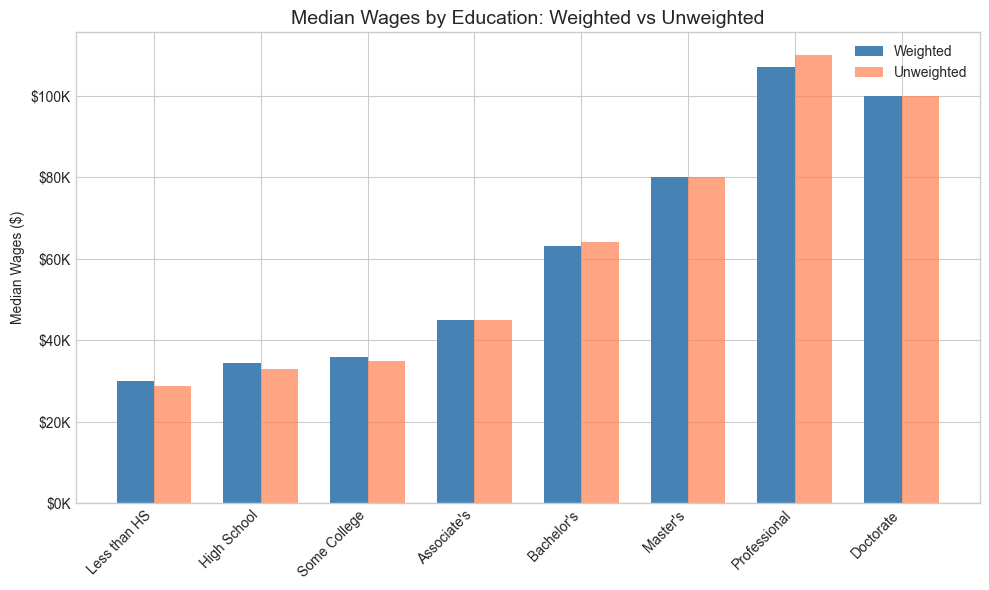

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(edu_wages_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], edu_wages_df['weighted_median'], width, 
               label='Weighted', color='steelblue')
bars2 = ax.bar([i + width/2 for i in x], edu_wages_df['unweighted_median'], width, 
               label='Unweighted', color='coral', alpha=0.7)

ax.set_title('Median Wages by Education: Weighted vs Unweighted', fontsize=14)
ax.set_ylabel('Median Wages ($)')
ax.set_xticks(x)
ax.set_xticklabels(edu_wages_df.index, rotation=45, ha='right')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

## Weighted Experience-Earnings Profile

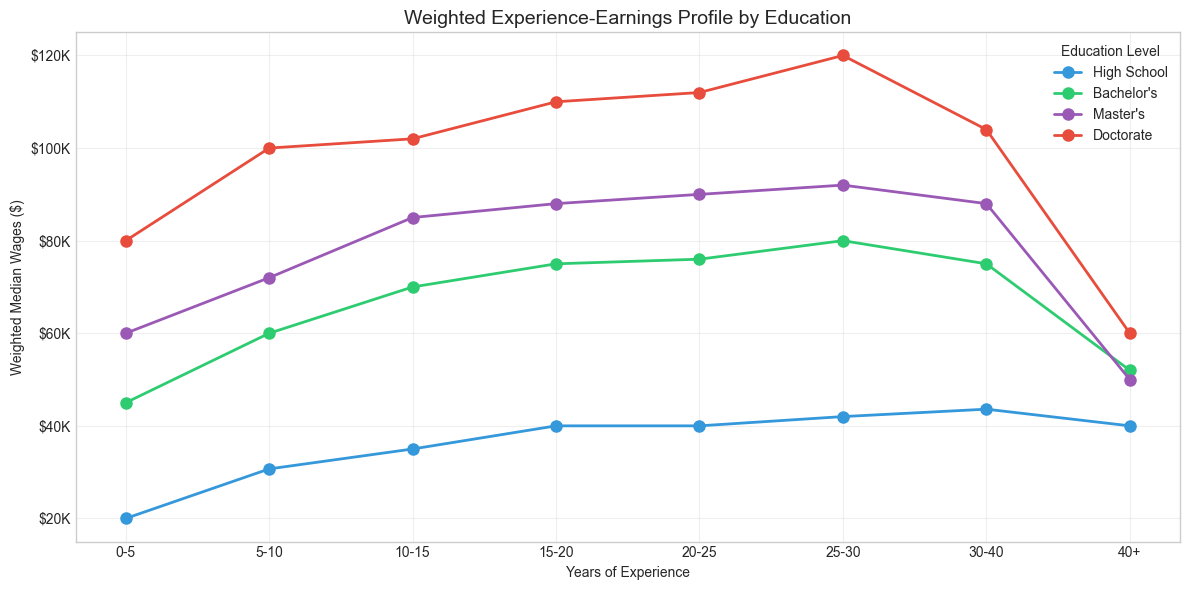

In [16]:
exp_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50]
exp_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', '40+']
workers['exp_group'] = pd.cut(workers['experience'], bins=exp_bins, labels=exp_labels)

fig, ax = plt.subplots(figsize=(12, 6))
edu_levels = ['High School', "Bachelor's", "Master's", 'Doctorate']
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']

for edu, color in zip(edu_levels, colors):
    edu_data = workers[workers['education_category'] == edu]
    if len(edu_data) > 0:
        exp_wages = []
        for exp in exp_labels:
            exp_data = edu_data[edu_data['exp_group'] == exp]
            if len(exp_data) > 10:
                w_med = weighted_median(exp_data['wagp'], exp_data['pwgtp'])
                exp_wages.append(w_med)
            else:
                exp_wages.append(np.nan)
        ax.plot(exp_labels, exp_wages, marker='o', label=edu, linewidth=2, markersize=8, color=color)

ax.set_title('Weighted Experience-Earnings Profile by Education', fontsize=14)
ax.set_xlabel('Years of Experience')
ax.set_ylabel('Weighted Median Wages ($)')
ax.legend(title='Education Level')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Weighted Education Premium

Weighted Education Premium (Prime-Age Workers 25-54)
Baseline: High School = $39,600

Less than HS        : $    31,000  (  -22% vs HS)
High School         : $    39,600  (+    0% vs HS)
Some College        : $    44,000  (+   11% vs HS)
Associate's         : $    49,500  (+   25% vs HS)
Bachelor's          : $    68,000  (+   72% vs HS)
Master's            : $    80,000  (+  102% vs HS)
Professional        : $   109,000  (+  175% vs HS)
Doctorate           : $   100,000  (+  153% vs HS)


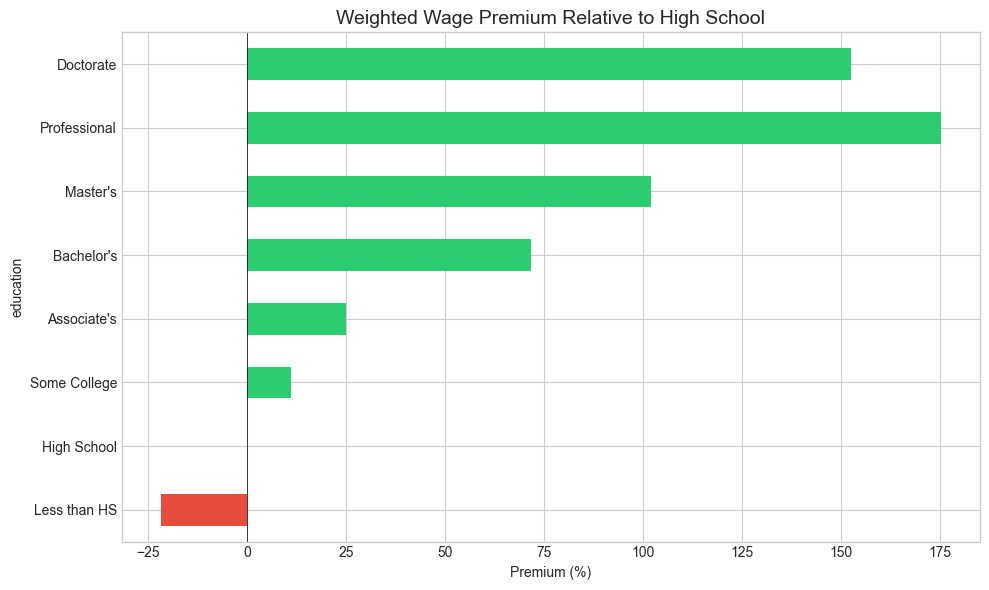

In [17]:
# Prime-age workers
prime_workers = df_person_sample[
    (df_person_sample['wagp'] > 0) & 
    (df_person_sample['agep'] >= 25) & 
    (df_person_sample['agep'] <= 54)
].copy()

# Calculate weighted median by education
edu_premium = []
for edu in edu_order:
    edu_data = prime_workers[prime_workers['education_category'] == edu]
    if len(edu_data) > 0:
        w_med = weighted_median(edu_data['wagp'], edu_data['pwgtp'])
        edu_premium.append({'education': edu, 'weighted_median': w_med})

edu_premium_df = pd.DataFrame(edu_premium).set_index('education')

# Calculate premium vs high school
hs_wage = edu_premium_df.loc['High School', 'weighted_median']
edu_premium_df['premium_pct'] = ((edu_premium_df['weighted_median'] / hs_wage) - 1) * 100

print("Weighted Education Premium (Prime-Age Workers 25-54)")
print("="*60)
print(f"Baseline: High School = ${hs_wage:,.0f}\n")
for edu in edu_order:
    if edu in edu_premium_df.index:
        row = edu_premium_df.loc[edu]
        sign = '+' if row['premium_pct'] >= 0 else ''
        print(f"{edu:<20}: ${row['weighted_median']:>10,.0f}  ({sign}{row['premium_pct']:>5.0f}% vs HS)")

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in edu_premium_df['premium_pct']]
edu_premium_df['premium_pct'].plot(kind='barh', ax=ax, color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_title('Weighted Wage Premium Relative to High School', fontsize=14)
ax.set_xlabel('Premium (%)')
plt.tight_layout()
plt.show()

## Weighted Wages by Field of Degree (College Major)

Analysis of wages by primary field of study for those with a bachelor's degree or higher.

In [ ]:
# Field of Degree mapping (from codebook)
FIELD_OF_DEGREE = {
    "1100": "General Agriculture", "1101": "Agriculture Production", "1102": "Agricultural Economics",
    "1103": "Animal Sciences", "1104": "Food Science", "1105": "Plant Science", "1106": "Soil Science",
    "1301": "Environmental Science", "1302": "Forestry", "1303": "Natural Resources",
    "1401": "Architecture",
    "1501": "Area/Ethnic Studies",
    "1901": "Communications", "1902": "Journalism", "1903": "Mass Media", "1904": "Advertising/PR",
    "2001": "Communication Technologies",
    "2100": "Computer & Info Systems", "2101": "Computer Programming", "2102": "Computer Science",
    "2105": "Information Sciences", "2106": "Computer Admin/Security", "2107": "Computer Networking",
    "2300": "General Education", "2304": "Elementary Education", "2307": "Early Childhood Ed",
    "2308": "Science/Computer Teacher Ed", "2309": "Secondary Teacher Ed", "2310": "Special Needs Ed",
    "2399": "Miscellaneous Education",
    "2400": "General Engineering", "2401": "Aerospace Engineering", "2404": "Biomedical Engineering",
    "2405": "Chemical Engineering", "2406": "Civil Engineering", "2407": "Computer Engineering",
    "2408": "Electrical Engineering", "2412": "Industrial Engineering", "2414": "Mechanical Engineering",
    "2499": "Miscellaneous Engineering",
    "2601": "Linguistics", "2602": "French/German/Latin", "2603": "Other Foreign Languages",
    "2901": "Family & Consumer Sciences",
    "3202": "Pre-Law/Legal Studies",
    "3301": "English Language & Literature", "3302": "Composition & Rhetoric",
    "3401": "Liberal Arts", "3402": "Humanities",
    "3600": "Biology", "3601": "Biochemical Sciences", "3603": "Molecular Biology",
    "3605": "Genetics", "3606": "Microbiology", "3611": "Neuroscience", "3699": "Misc Biology",
    "3700": "Mathematics", "3701": "Applied Mathematics", "3702": "Statistics",
    "4000": "Interdisciplinary Studies", "4002": "Nutrition Sciences", "4005": "Math & Computer Science",
    "4006": "Cognitive Science", "4009": "Data Science",
    "4101": "Physical Fitness/Recreation",
    "4801": "Philosophy & Religious Studies", "4901": "Theology",
    "5000": "Physical Sciences", "5001": "Astronomy", "5002": "Atmospheric Sciences",
    "5003": "Chemistry", "5004": "Geology", "5007": "Physics",
    "5200": "Psychology", "5202": "Clinical Psychology", "5203": "Counseling Psychology",
    "5205": "Industrial/Org Psychology", "5299": "Misc Psychology",
    "5301": "Criminal Justice",
    "5401": "Public Administration", "5402": "Public Policy", "5404": "Social Work",
    "5500": "General Social Sciences", "5501": "Economics", "5502": "Anthropology",
    "5503": "Criminology", "5504": "Geography", "5505": "International Relations",
    "5506": "Political Science", "5507": "Sociology",
    "6000": "Fine Arts", "6001": "Drama/Theater", "6002": "Music", "6003": "Visual/Performing Arts",
    "6004": "Graphic Design", "6005": "Film/Video/Photography", "6006": "Art History",
    "6100": "General Health Services", "6102": "Communication Disorders", "6103": "Health Admin",
    "6105": "Medical Technologies", "6106": "Health/Medical Prep", "6107": "Nursing",
    "6108": "Pharmacy", "6109": "Treatment/Therapy", "6110": "Public Health", "6199": "Misc Health",
    "6200": "General Business", "6201": "Accounting", "6202": "Actuarial Science",
    "6203": "Business Management", "6204": "Operations/Logistics", "6205": "Business Economics",
    "6206": "Marketing", "6207": "Finance", "6209": "Human Resources", "6210": "International Business",
    "6211": "Hospitality Management", "6212": "Management Info Systems",
    "6402": "History", "6403": "United States History",
}

# Filter to workers with bachelor's degree or higher (schl >= 21) and valid field of degree
college_workers = workers[
    (workers['schl'] >= 21) & 
    (workers['fod1p'].notna()) & 
    (workers['fod1p'] != 'N')
].copy()

# Map field of degree codes to names
college_workers['field_of_degree'] = college_workers['fod1p'].astype(str).map(FIELD_OF_DEGREE)
college_workers['field_of_degree'] = college_workers['field_of_degree'].fillna('Other')

print(f"College-educated workers with field of degree: {len(college_workers):,}")
print(f"Weighted total: {college_workers['pwgtp'].sum():,.0f}")

In [ ]:
# Calculate weighted median wages by field of degree
fod_wages = []
for fod in college_workers['field_of_degree'].unique():
    fod_data = college_workers[college_workers['field_of_degree'] == fod]
    if len(fod_data) >= 30:  # Minimum sample size for reliability
        w_med = weighted_median(fod_data['wagp'], fod_data['pwgtp'])
        w_count = fod_data['pwgtp'].sum()
        fod_wages.append({
            'field': fod, 
            'weighted_median': w_med, 
            'weighted_count': w_count,
            'sample_size': len(fod_data)
        })

fod_wages_df = pd.DataFrame(fod_wages).set_index('field').sort_values('weighted_median', ascending=False)

# Top 20 highest paying fields
print("Top 20 Highest Paying Fields of Degree")
print("="*70)
print(f"{'Field':<35} {'Median Wage':>15} {'Est. Workers':>15}")
print("-"*70)
for field in fod_wages_df.head(20).index:
    row = fod_wages_df.loc[field]
    print(f"{field[:34]:<35} ${row['weighted_median']:>14,.0f} {row['weighted_count']:>14,.0f}")

In [ ]:
# Visualize top and bottom paying fields
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 highest paying
ax = axes[0]
top_15 = fod_wages_df.head(15).sort_values('weighted_median')
top_15['weighted_median'].plot(kind='barh', ax=ax, color='#2ecc71')
ax.set_title('Top 15 Highest Paying Fields of Degree', fontsize=12)
ax.set_xlabel('Weighted Median Wage ($)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Bottom 15 (among those with sufficient sample)
ax = axes[1]
bottom_15 = fod_wages_df.tail(15).sort_values('weighted_median')
bottom_15['weighted_median'].plot(kind='barh', ax=ax, color='#e74c3c')
ax.set_title('Bottom 15 Paying Fields of Degree', fontsize=12)
ax.set_xlabel('Weighted Median Wage ($)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

In [ ]:
# Group fields into broader categories for summary
def categorize_field(field):
    if field is None:
        return 'Other'
    field_lower = field.lower()
    if any(x in field_lower for x in ['engineering', 'computer', 'data science', 'info system']):
        return 'STEM: Engineering & Computer Science'
    elif any(x in field_lower for x in ['biology', 'chemistry', 'physics', 'math', 'statistics', 'science']):
        return 'STEM: Natural Sciences & Math'
    elif any(x in field_lower for x in ['business', 'accounting', 'finance', 'marketing', 'economics', 'management']):
        return 'Business & Economics'
    elif any(x in field_lower for x in ['health', 'nursing', 'pharmacy', 'medical', 'therapy']):
        return 'Health & Medical'
    elif any(x in field_lower for x in ['education', 'teacher']):
        return 'Education'
    elif any(x in field_lower for x in ['psychology', 'social', 'sociology', 'political', 'criminal']):
        return 'Social Sciences'
    elif any(x in field_lower for x in ['art', 'music', 'drama', 'film', 'design', 'visual']):
        return 'Arts & Design'
    elif any(x in field_lower for x in ['english', 'history', 'philosophy', 'liberal', 'humanities', 'language']):
        return 'Humanities & Liberal Arts'
    elif any(x in field_lower for x in ['communication', 'journalism', 'media']):
        return 'Communications & Media'
    else:
        return 'Other'

college_workers['field_category'] = college_workers['field_of_degree'].apply(categorize_field)

# Calculate weighted stats by category
cat_wages = []
for cat in college_workers['field_category'].unique():
    cat_data = college_workers[college_workers['field_category'] == cat]
    if len(cat_data) >= 30:
        w_med = weighted_median(cat_data['wagp'], cat_data['pwgtp'])
        w_count = cat_data['pwgtp'].sum()
        cat_wages.append({'category': cat, 'weighted_median': w_med, 'weighted_count': w_count})

cat_wages_df = pd.DataFrame(cat_wages).set_index('category').sort_values('weighted_median', ascending=False)

print("\nWeighted Median Wages by Field Category")
print("="*70)
print(f"{'Category':<40} {'Median Wage':>15} {'Est. Workers':>12}")
print("-"*70)
for cat in cat_wages_df.index:
    row = cat_wages_df.loc[cat]
    print(f"{cat:<40} ${row['weighted_median']:>14,.0f} {row['weighted_count']:>11,.0f}")

In [ ]:
# Visualize by category
fig, ax = plt.subplots(figsize=(12, 6))

cat_wages_sorted = cat_wages_df.sort_values('weighted_median')
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(cat_wages_sorted)))
cat_wages_sorted['weighted_median'].plot(kind='barh', ax=ax, color=colors)

ax.set_title('Weighted Median Wages by Field of Degree Category', fontsize=14)
ax.set_xlabel('Weighted Median Wage ($)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels
for i, (idx, row) in enumerate(cat_wages_sorted.iterrows()):
    ax.text(row['weighted_median'] + 1000, i, f"${row['weighted_median']/1000:.0f}K", 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Calculate STEM premium
stem_eng = cat_wages_df.loc['STEM: Engineering & Computer Science', 'weighted_median']
humanities = cat_wages_df.loc['Humanities & Liberal Arts', 'weighted_median']
print(f"\nSTEM (Eng/CS) vs Humanities wage premium: {((stem_eng/humanities)-1)*100:.0f}%")

In [ ]:
# Gender wage gap by field category
print("Gender Wage Gap by Field of Degree Category")
print("="*75)
print(f"{'Category':<35} {'Male':>12} {'Female':>12} {'Gap':>8}")
print("-"*75)

for cat in cat_wages_df.index:
    cat_data = college_workers[college_workers['field_category'] == cat]
    male_data = cat_data[cat_data['sex_desc'] == 'Male']
    female_data = cat_data[cat_data['sex_desc'] == 'Female']
    
    if len(male_data) >= 30 and len(female_data) >= 30:
        male_med = weighted_median(male_data['wagp'], male_data['pwgtp'])
        female_med = weighted_median(female_data['wagp'], female_data['pwgtp'])
        gap = (male_med - female_med) / male_med * 100
        print(f"{cat[:34]:<35} ${male_med:>10,.0f} ${female_med:>10,.0f} {gap:>7.1f}%")

## Weighted Gender Wage Gap

Weighted Gender Wage Analysis
Male median wage:   $50,000
Female median wage: $40,000
Gender wage gap:    20.0%

Women earn $0.80 for every $1 men earn


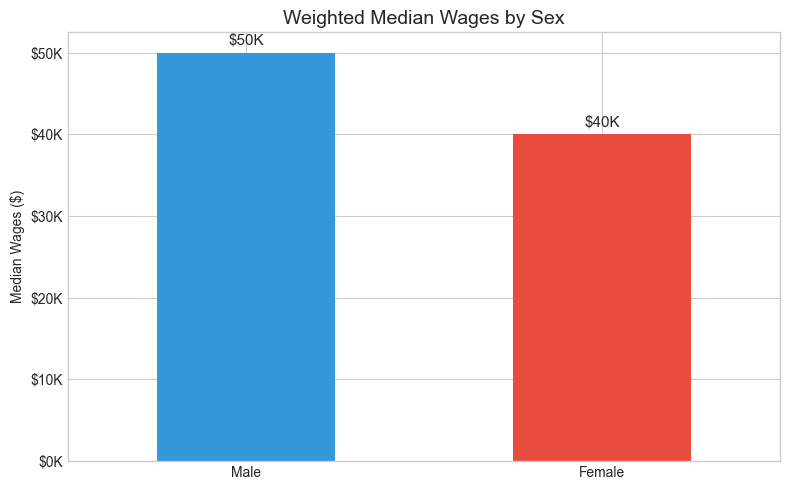

In [18]:
male_wage = weighted_median(
    workers[workers['sex_desc'] == 'Male']['wagp'],
    workers[workers['sex_desc'] == 'Male']['pwgtp']
)
female_wage = weighted_median(
    workers[workers['sex_desc'] == 'Female']['wagp'],
    workers[workers['sex_desc'] == 'Female']['pwgtp']
)

gap = (male_wage - female_wage) / male_wage * 100

print("Weighted Gender Wage Analysis")
print("="*40)
print(f"Male median wage:   ${male_wage:,.0f}")
print(f"Female median wage: ${female_wage:,.0f}")
print(f"Gender wage gap:    {gap:.1f}%")
print(f"\nWomen earn ${female_wage/male_wage:.2f} for every $1 men earn")

fig, ax = plt.subplots(figsize=(8, 5))
wages = pd.Series({'Male': male_wage, 'Female': female_wage})
wages.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_title('Weighted Median Wages by Sex', fontsize=14)
ax.set_ylabel('Median Wages ($)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

for i, v in enumerate(wages):
    ax.text(i, v + 1000, f'${v/1000:.0f}K', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## Summary: Weighted vs Unweighted Comparison

In [19]:
print("="*70)
print("WEIGHTED VS UNWEIGHTED COMPARISON")
print("="*70)

# Household income
hh_pos = df_hh_sample[df_hh_sample['hincp'] > 0]
w_hh_med = weighted_median(hh_pos['hincp'], hh_pos['wgtp'])
uw_hh_med = hh_pos['hincp'].median()

print(f"\nHousehold Income Median:")
print(f"  Weighted:   ${w_hh_med:,.0f}")
print(f"  Unweighted: ${uw_hh_med:,.0f}")
print(f"  Difference: {(w_hh_med - uw_hh_med) / uw_hh_med * 100:+.1f}%")

# Bachelor's wage
bach = workers[workers['education_category'] == "Bachelor's"]
w_bach = weighted_median(bach['wagp'], bach['pwgtp'])
uw_bach = bach['wagp'].median()

print(f"\nBachelor's Degree Median Wage:")
print(f"  Weighted:   ${w_bach:,.0f}")
print(f"  Unweighted: ${uw_bach:,.0f}")
print(f"  Difference: {(w_bach - uw_bach) / uw_bach * 100:+.1f}%")

print("\n" + "="*70)
print("Note: Differences occur because the sample is not perfectly")
print("representative. Weights adjust for sampling design and nonresponse.")
print("="*70)

WEIGHTED VS UNWEIGHTED COMPARISON

Household Income Median:
  Weighted:   $78,000
  Unweighted: $80,000
  Difference: -2.5%

Bachelor's Degree Median Wage:
  Weighted:   $63,000
  Unweighted: $64,000
  Difference: -1.6%

Note: Differences occur because the sample is not perfectly
representative. Weights adjust for sampling design and nonresponse.
